In [1]:
%pylab inline
from math import gcd as GCD
from scipy.sparse.coo import coo_matrix as sparsemat
from scipy.sparse.linalg import svds as sparsesvd
from itertools import combinations
from numpy import mean as mean
import time
from scipy.special import comb as bin_coeff

Populating the interactive namespace from numpy and matplotlib


In [2]:
def decimal_to_binary(number,length):
    '''
        Returns binary representation of number as string of minimum length length
        
        Parameters
            ----------
            number:  Integer
                     decimal number to be converted in binary form
                     
            length:  Integer
                     minimum length of the string
                     
            ----------
            Example:
            decimal_to_binary(2,5) will yield str(00010)    
    '''
    
    return np.binary_repr(number,length)
    

def to_decimal(string_list):
    '''
        converts a list of strings representing a binary number and returns
        its decimal representation as integer
        
        Parameters
            ----------
            string_array:  List
                     list of binary strings to be converted
    '''
    
    string="".join(string_list)
    return int(string,2)    


def find_coprime(N):     
    """
            Find a coprime of N for N>2
            Parameters
            ----------
            N:  Integer
                Number to find the coprime of

    """
    if(N<3):
        raise ValueError("Illegal argument: coprimes exist for N>2")
    Y=randint(2,N)
    used=[]
    while 1:
        a=GCD(Y,N)
        if (a>1):
            #this Y is not coprime
            used.append(Y)
            while(Y in used):
                Y=randint(2,N)
        else: return Y

In [14]:
def notchosen(chosen,system_size):
    """
            Return array containing the qubit NOT in the partition
            
            Parameters
            ----------                
            chosen:   List
                List of the qubits selected as partition, in the form [1,3,7,..]
                
            system_size: Integer
                Total number of qubits
                    
    """
    
    notchosen=list(set(list(range(system_size)))-set(chosen))
    notchosen.sort()
    return notchosen

def split_components(array,chosen):
    '''
    Given an input array and selected components returns only the selected components.
    '''
    if( max(chosen) not in range(len(array)))  :
        raise ValueError('the chosen '+str(max(chosen))+' bit is not present in a '+str(len(array))+' bits register')
    return [array[i] for i in chosen]


def create_W(k,Y,N,chosen):
    '''
    creates W directly
    
    '''
    
    L=int(ceil(log2(N)))
    if(k>2*L):
        raise ValueError(str(k)+"th computational step does not make sense in a "+str(2*L)+" qubits control register")
    
    #nonzero elements of psi in binary form
    nonzeros=[decimal_to_binary(m*2**L+(Y**m%N),k+L) for m in range(2**k)]
    not_chosen=notchosen(chosen,k+L)   
        
    indexes=[ (to_decimal(split_components(i,chosen)),to_decimal((split_components(i,not_chosen)))) for i in nonzeros]
    
    row=[elem[0] for elem in indexes]
    col=[elem[1] for elem in indexes]
    data=np.ones(2**k)*(2**(-k/2))
    
    return sparsemat((data,(row,col)), shape=(2**len(chosen),2**len(not_chosen))    ).tocsc()

def entanglement_entropy(k,Y,N,chosen):
    #global W_time
    #t0=time.time()
    W=create_W(k,Y,N,chosen)
    #W_time.append(time.time()-t0)
    
    #global svd_time
    #t0=time.time()
    eigs=sparsesvd(W,k=min(shape(W))-1,which='LM',return_singular_vectors=False)
    eigs=eigs*eigs
    entr=-np.sum([i*np.log2(i) for i in eigs if i>0])
    
    #svd_time.append(time.time()-t0)
    return entr

In [4]:
N=21
L=int(ceil(log2(N)))
#Y=find_coprime(N)
#print(Y)
Y=13 #N,Y=(3,2),(6,5),(10,7),(11,8),(21,17), (64,57)

In [18]:
%%time
#times:
#for all ks: (3..4,56 ms), (5..8,471 ms)
#      (9..16,8s) (N=17..32,210s) not feasible for N=33,..,64

W_time=[]
svd_time=[]

entropy=[entanglement_entropy(k,Y,N,chosen) for k in range(1,2*L+1) for chosen in combinations(range(k+L),(k+L)//2)]

#entropy[0] will contain all computational steps of first chosen partition

KeyboardInterrupt: 

6.620138168334961 1.3062546253204346


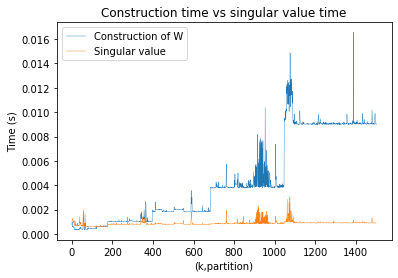

In [255]:
fig = plt.figure()
ax = plt.subplot(111)

plt.title("Construction time vs singular value time")
plt.ylabel("Time (s)")
plt.xlabel("(k,partition)")

ax.plot(range(len(W_time)),[i for i in W_time],label="Construction of W",linewidth=0.4) #blue
ax.plot(range(len(svd_time)),[i for i in svd_time],label="Singular value",linewidth=0.4) #orange
ax.legend()
#plt.savefig("ConstructionVsSingularValue2.png",dpi=300)
print(sum(W_time),sum(svd_time))

In [75]:
#W_split=W_time
#W_take=W_time

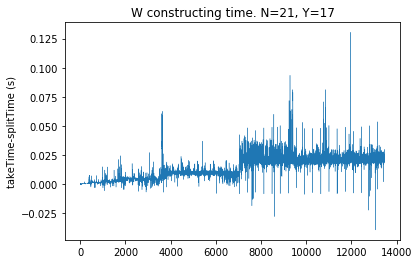

In [88]:
#plot(range(len(W_time)),[i for i in W_split]) #blue
#plot(range(len(W_time)),[i for i in W_take]) #orange

#total time(s): (split,426) (take,606)

plt.plot(range(len(W_time)),array(W_take)-array(W_split),linewidth=0.4) #orange
plt.title("W constructing time. N=21, Y=17")
plt.ylabel("takeTime-splitTime (s)")
#plt.savefig("takeVsSplit",dpi=300)

In [15]:
import random

def random_combination(iterable, r):
    "Random selection from itertools.combinations(iterable, r)"
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted(random.sample(range(n), r))
    return tuple(pool[i] for i in indices)


def average_entropy(k,Y,N,maxiter=10000, return_singles=True,
                    tol=1e-4,step=100):
    '''
    Computes and return an approximate entanglement entropy of the system
    averaged on all possible balanced bipartitions. It stops when the estimate is stable
    
    It returns (niter,average,singles,combinations) if return_singles=True
    Only first two elements when flag is False
    '''

    if(not return_singles): return average_entropy_in_place(k,Y,N,maxiter,tol,step)
    

    niter=maxiter
    results=[]
    L=int(ceil(log2(N)))
    qubits=range(k+L)
    partition_dimension= len(qubits)//2
    combinations=[]
    entropies=[]
    previous_mean=0
    
    for i in range(maxiter):
        i+=1
        current_comb=random_combination(qubits,partition_dimension)
        #extracting each combination at most once
        while(current_comb in combinations):
            current_comb=random_combination(qubits,partition_dimension)            
        combinations.append(current_comb)
        current_entropy=entanglement_entropy(k,Y,N,current_comb)
        entropies.append(current_entropy)
        current_mean=mean(entropies)
        
        if(i==step):
            previous_mean=current_mean
            continue
            
        if(i+1%step==0):
            if(np.abs(current_mean-previous_mean)<tol):
                return (i,current_mean,entropies,combinations)
            previous_mean=current_mean
        
    return (maxiter,mean(entropies),entropies,combinations)


def average_entropy_in_place(k,Y,N,maxiter=10000,tol=1e-4,step=100):
    
    L=int(ceil(log2(N)))
    qubits=range(k+L)
    partition_dimension= len(qubits)//2
    total_entropy=0
    combinations=[]
    prev=0

    for i in range(maxiter):
        i+=1
        current_comb=random_combination(qubits,partition_dimension)
        #extracting each combination at most once
        while(current_comb in combinations):
            current_comb=random_combination(qubits,partition_dimension)            
        combinations.append(current_comb)
        
        total_entropy+=entanglement_entropy(k,Y,N,current_comb)
        if(i==step):
            previous_mean=total_entropy/i
            continue
        
        if(i%step==0):
            current_mean=total_entropy/i
            if(np.abs(current_mean-previous_mean)<tol):
                return (i,current_mean)
            previous_mean=current_mean
            
    return (maxiter,total_entropy/maxiter)

In [16]:
%%time
iterations,average,singles,comb=average_entropy(2*L,Y,N,1000,True)
print(iterations,average)

1000 0.814
CPU times: user 38.1 s, sys: 1.08 s, total: 39.2 s
Wall time: 19.6 s


In [48]:
%%time
N=12
L=int(ceil(log2(N)))
entropy=[entanglement_entropy(k,Y,N,chosen) for k in range(1,2*L+1) for chosen in combinations(range(k+L),(k+L)//2)]

CPU times: user 12.3 s, sys: 328 ms, total: 12.6 s
Wall time: 7.44 s


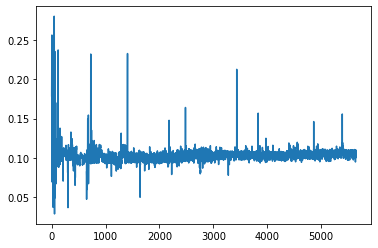

In [192]:
plot([j/i for i,j in zip(oldtime,nonzero_time)])

In [188]:
def decimal_to_binary(number,length):
    '''return binary representation as string'''
    return np.binary_repr(number,length)
    
def to_decimal(string_array):
    '''takes array of strings representing binary number and returns
     its decimal representation'''
    string="".join(string_array)
    return int(string,2)

In [167]:
test1=decimal_to_binary(10,5)
print(test1)

01010


In [169]:
test2=split_components(test1,[2,4])
print(test2)

['0', '0']


In [170]:
to_decimal(test2)

0

In [12]:
L=int(ceil(log2(33)))
print(sum([number_of_bipartitions(k+L) for k in range(0,2*L)]))
print(np.shape([(i,k) for k in range(0,2*L) for i in combinations(range(k+L),(k+L)//2)]))

50652
(50652, 2)


In [13]:
def number_of_bipartitions(size):
    return bin_coeff(size,size//2,exact=True)

In [17]:
L=int(ceil(log2(N)))
number_of_bipartitions(3*L)

6435